In [18]:
from random import choice

def pairs(L, typeCons):
   return [(typeCons(L[i]), typeCons(L[i+1])) for i in range(0, len(L) - 1, 2)]


def processLine(stockLine):
   tokens = stockLine.split(',')
   return [tokens[0]] + pairs(tokens[1:], float)


def transpose(A):
   column = lambda A,j: [row[j] for row in A]
   return [column(A, j) for j in range(len(A[0]))]


def readInStockTable(filename):
   with open(filename, 'r') as infile:
      lines = infile.readlines()

   headers = lines[0].strip().split(',')
   numericalTable = [[headers[0]] + pairs(headers[1:], str)] + [processLine(line) for line in lines[1:]]
   preDictTable = transpose(numericalTable)[1:]

   # converting to a dictionary 
   stockHistoryDict = {}
   for singleStockHistory in preDictTable:
      ticker = singleStockHistory[0][0].split('-')[0]
      stockHistoryDict[ticker] = singleStockHistory[1:]

   return stockHistoryDict


# Compute the payoff of buying 1$ worth of shares at the opening and closing
def payoff(stockTable, t, stock, amountToInvest=1.0):
   openPrice, closePrice = stockTable[stock][t]

   sharesBought = amountToInvest / openPrice
   amountAfterSale = sharesBought * closePrice

   return amountAfterSale - amountToInvest


def payoffGraph(table, tickers, cumulative=True):

   from matplotlib import pyplot as plt
   import numpy

   numRounds = len(table[tickers[0]])
   numActions = len(tickers)

   reward = lambda choice, t: payoff(table, t, choice)
   singleActionRewards = lambda s: numpy.array([reward(s,t) for t in range(numRounds)])
   xs = numpy.array(list(range(numRounds)))

   ax1 = plt.subplot(111)

   if cumulative:
      plt.title("Cumulative stock rewards over time")
   else:
      plt.title("Stock rewards over time")

   plt.ylabel('Reward')
   plt.xlabel('Day')

   for ticker in tickers:
      if cumulative:
         ax1.plot(xs, numpy.cumsum(singleActionRewards(ticker)), label=ticker)
      else:
         ax1.plot(xs, singleActionRewards(ticker), label=ticker)

   plt.legend()
   plt.show()

In [19]:
import math
import random
import csv


# the size of the upper confidence bound for ucb1
def upperBound(step, numPlays):
   return math.sqrt(2.0 * math.log(step + 1) / numPlays)


def ucb1(numActions, reward):
   payoffSums = [0.0] * numActions
   numPlays = [1] * numActions
   ucbs = [0.0] * numActions

   # initializing empirical sums
   for t in range(numActions):
      payoffSums[t] = reward(t,t)
      yield t, payoffSums[t], ucbs

   t = numActions

   while True:
      ucbs = [payoffSums[i] / numPlays[i] + upperBound(t, numPlays[i]) for i in range(numActions)]
      action = max(range(numActions), key=lambda i: ucbs[i])
      theReward = reward(action, t)
      numPlays[action] += 1
      payoffSums[action] += theReward

      yield action, theReward, ucbs
      t = t + 1

For a single run: 
Best stock was amzn at 2.54


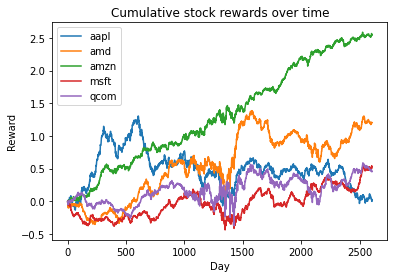

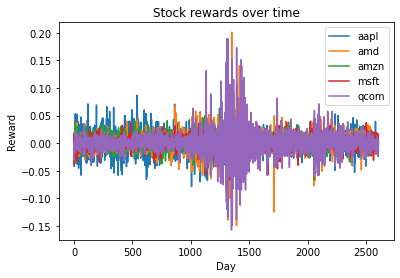

In [20]:
from random import shuffle

def ucb1Stocks(stockTable):
   tickers = list(stockTable.keys())
   shuffle(tickers) 
   numRounds = len(stockTable[tickers[0]])
   numActions = len(tickers)

   reward = lambda choice, t: payoff(stockTable, t, tickers[choice])
   singleActionReward = lambda j: sum([reward(j,t) for t in range(numRounds)])

   bestAction = max(range(numActions), key=singleActionReward)
   bestActionCumulativeReward = singleActionReward(bestAction)

   cumulativeReward = 0
   t = 0
   ucb1Generator = ucb1(numActions, reward)
   for (chosenAction, reward, ucbs) in ucb1Generator:
      cumulativeReward += reward
      t += 1
      if t == numRounds:
         break

   return cumulativeReward, bestActionCumulativeReward, ucbs, tickers[bestAction]


prettyList = lambda L: ', '.join(['%.3f' % x for x in L])
payoffStats = lambda data: stats(ucb1Stocks(data)[0] for _ in range(1000))


def runExperiment(table):
   #print("(Expected payoff, variance) over 1000 trials is %r" % (payoffStats(table),))
   reward, bestActionReward, ucbs, bestStock = ucb1Stocks(table)
   print("For a single run: ")
   #print("Reward was %.2f" % reward)
   #print("Regret was %.2f" % (bestActionReward - reward))
   print("Best stock was %s at %.2f" % (bestStock, bestActionReward))
   #print("ucbs: %r" % prettyList(ucbs))


if __name__ == "__main__":
   table = readInStockTable('stock.csv')
   #table=csv.reader('stock.csv')
   runExperiment(table)
   payoffGraph(table, list(sorted(table.keys())), cumulative=True)
   payoffGraph(table, list(sorted(table.keys())), cumulative=False)

   print()